# Data Context


The main focus of the research is to investigate the value of Federated Learning techniques on a Predictive Maintenance use-case using operational data from multiple airline fleets, within a consortium governed Digital Data Marketplace (DDM) ecosystem. In the real world, there will be no direct access to this operational data as the this data is held privately and is confidential. The main idea of Federated Learning is to train a model across multiple decentralized edge nodes holding local data, without exposing or transmitting privately held data. For the actual experiments within a DDM, airline operational dataset(s) related to Boeing aircraft(s) such as 787 Supplemental Cooling Unit(SCU), or 747 Bleed Air Valves will be used. This data is private. 

As an alternative to private and confidential airline operational datasets, publicly available dataset is  being explored during the research to make comparisons between centralized and federated learning methods. This simulated dataset is provided by the NASA Ames Prognostics Center of Excellence (PCoE). Engine degradation simulation was carried out using the Commercial Modular Aero-Propulsion System Simulation (C-MAPSS). Four different sets (FD001, FD002, FD003, FD004) were simulated under different combinations of operational conditions and fault modes. This records several sensor channels to characterize fault evolution. <BR>


<B>References</B> :
    
1. Data Set Download: https://data.nasa.gov/Aerospace/CMAPSS-Jet-Engine-Simulated-Data/ff5v-kuh6 
2. Data Set Citation: A. Saxena, K. Goebel, D. Simon, and N. Eklund, Damage Propagation Modeling for Aircraft Engine Run-to-Failure Simulation, in the Proceedings of the Ist International Conference on Prognostics and Health Management (PHM08), Denver CO, Oct 2008.

## Data Description

### Data Set
All the data sets consist of multiple multivariate time series. Each data set is further divided into training and test subsets. Each time series is from a different engine i.e., the data can be considered to be from a fleet of engines of the same type. Each engine starts with different degrees of initial wear and manufacturing variation which is unknown to the user. This wear and variation is considered normal, i.e., it is not considered a fault condition. There are three operational settings that have a substantial effect on engine performance. These settings are also included in the data. The data is contaminated with sensor noise.The engine is operating normally at the start of each time series, and develops a fault at some point during the series. In the training set, the fault grows in magnitude until system failure. In the test set, the time series ends some time prior to system failure. The objective is to predict the number of remaining operational cycles before failure in the test set, i.e., the number of operational cycles after the last cycle that the engine will continue to operate. The data set also includes a vector of true Remaining Useful Life (RUL) values for the test data.

There are 4 datasets available as part of the CMAPSS download. Data Set FD001 is used as the public dataset for this research project. The dataset includes train data, test data and ground truth Remaining Useful Life (RUL) values for the test data. Further, for Federated Learning experiments, the training data will be split into one subset for initial training (10 engines) and 3 subsets for each of Federated Learning Nodes (30 engines each). The test data will also be split for validation and testing.<BR>

### Structure
The data are provided as a zip-compressed text file with 26 columns of numbers, separated by spaces. Each row is a snapshot of data taken during a single operational cycle, each column is a different variable. The columns correspond to:
1)	unit number<BR>
2)	time, in cycles<BR>
3)	operational setting 1<BR>
4)	operational setting 2<BR>
5)	operational setting 3<BR>
6)	sensor measurement  1<BR>
7)	sensor measurement  2<BR>
...<BR>
26)	sensor measurement  26<BR>

### Analysis 
* Data Set FD001 has data from 100 engines and has 20631 entries. 
* 'Operational setting 3', and Sensor Measurements 1, 5, 6, 10, 16, 18,19 have constant values and hence hold no information related to RUL.
* Correlation : There is high correlation ( close to 1 or -1 )  between the following sensor pairs: (4,11), (4,12), (7,11), (7,12), (8,13), (9,14), (11,12)
* Target Variable: A  variable for Remaining User Life (RUL) will be computed. This will also serve as a target variable for supervised learning.As there is no information about RUL in the training data, we assume that the RUL decreases linearly with time and will have a value of 0 at the last time cycle of the engine. The calculated RUL and the histogram show that most engines breakdown around 200 cycles and the distribution is right skewed.
* Trends : The various sensor plots w.r.t RUL show that Sensors 1, 5, 10, 16, 18 and 19 do not indicate a increasing or decreasing trend. They are constant. Sensors 2, 3, 4, 8, 11, 13, 15 and 17 indicate an increasing trend. Sensor 7, 12, 20, 21 indicate an declining trend. Sensor  6 peaks downwards but is not clear. Sensor 9 and Sensor 14 display similar pattern with gradual change for a while and then indicate an abrupt increasing or decreasing trend, at certain point in time.
* Experiments : Regression experiments to predict the RUL value, using supervised learning will be setup and performed in the Federated Learning Environment. The picture below depcits the overall flow including the data that will be used. The results from federated learning will then be compared to (non-federated) centralized learning methods.

    
![image](https://github.com/ben7pram/ddm-fl-project-2023/blob/main/notebooks/eda-1.png?raw=1)

In [67]:
# Imports
import os
import numpy as np
import pandas as pd
import math
import random
import matplotlib.pyplot as plt
import seaborn as sns; 

from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.ensemble import RandomForestRegressor

### Data Loading

In [34]:
# CMAPSS FD001 DataSet 
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
cd drive/MyDrive/

[Errno 2] No such file or directory: 'drive/MyDrive/'
/content/drive/MyDrive


In [36]:
# define filepath to read data
dir_path = 'data/'

# define column names for easy indexing
index_names = ['unit_nr', 'time_cycles']
setting_names = ['setting_1', 'setting_2', 'setting_3']
sensor_names = ['s_{}'.format(i) for i in range(1,22)] 
col_names = index_names + setting_names + sensor_names

# read data
train = pd.read_csv((dir_path+'train_FD001.txt'), sep='\s+', header=None, names=col_names)
test = pd.read_csv((dir_path+'test_FD001.txt'), sep='\s+', header=None, names=col_names)
y_test = pd.read_csv((dir_path+'RUL_FD001.txt'), sep='\s+', header=None, names=['RUL'])

train.head()

,unit_nr,time_cycles,setting_1,setting_2,setting_3,s_1,s_2,s_3,s_4,s_5,...,s_12,s_13,s_14,s_15,s_16,s_17,s_18,s_19,s_20,s_21
0,1,1,-0.0007,-0.0004,100.0,518.67,641.82,1589.70,1400.60,14.62,...,521.66,2388.02,8138.62,8.4195,0.03,392,2388,100.0,39.06,23.4190
1,1,2,0.0019,-0.0003,100.0,518.67,642.15,1591.82,1403.14,14.62,...,522.28,2388.07,8131.49,8.4318,0.03,392,2388,100.0,39.00,23.4236
2,1,3,-0.0043,0.0003,100.0,518.67,642.35,1587.99,1404.20,14.62,...,522.42,2388.03,8133.23,8.4178,0.03,390,2388,100.0,38.95,23.3442
3,1,4,0.0007,0.0000,100.0,518.67,642.35,1582.79,1401.87,14.62,...,522.86,2388.08,8133.83,8.3682,0.03,392,2388,100.0,38.88,23.3739
4,1,5,-0.0019,-0.0002,100.0,518.67,642.37,1582.85,1406.22,14.62,...,522.19,2388.04,8133.80,8.4294,0.03,393,2388,100.0,38.90,23.4044


### Descriptive Statistics


In [37]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20631 entries, 0 to 20630
Data columns (total 26 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   unit_nr      20631 non-null  int64  
 1   time_cycles  20631 non-null  int64  
 2   setting_1    20631 non-null  float64
 3   setting_2    20631 non-null  float64
 4   setting_3    20631 non-null  float64
 5   s_1          20631 non-null  float64
 6   s_2          20631 non-null  float64
 7   s_3          20631 non-null  float64
 8   s_4          20631 non-null  float64
 9   s_5          20631 non-null  float64
 10  s_6          20631 non-null  float64
 11  s_7          20631 non-null  float64
 12  s_8          20631 non-null  float64
 13  s_9          20631 non-null  float64
 14  s_10         20631 non-null  float64
 15  s_11         20631 non-null  float64
 16  s_12         20631 non-null  float64
 17  s_13         20631 non-null  float64
 18  s_14         20631 non-null  float64
 19  s_15

In [38]:
# Number of  engines
len(train['unit_nr'].unique())

100

In [39]:
# inspect unit_nr
train[index_names].describe()

,unit_nr,time_cycles
count,20631.000000,20631.000000
mean,51.506568,108.807862
std,29.227633,68.880990
min,1.000000,1.000000
25%,26.000000,52.000000
50%,52.000000,104.000000
75%,77.000000,156.000000
max,100.000000,362.000000


In [40]:
# time cycles
train[index_names].groupby('unit_nr').max().describe()

,time_cycles
count,100.000000
mean,206.310000
std,46.342749
min,128.000000
25%,177.000000
50%,199.000000
75%,229.250000
max,362.000000


In [41]:
# settings
train[setting_names].describe()

,setting_1,setting_2,setting_3
count,20631.000000,20631.000000,20631.0
mean,-0.000009,0.000002,100.0
std,0.002187,0.000293,0.0
min,-0.008700,-0.000600,100.0
25%,-0.001500,-0.000200,100.0
50%,0.000000,0.000000,100.0
75%,0.001500,0.000300,100.0
max,0.008700,0.000600,100.0


In [42]:
# sensor values
train[sensor_names].describe().transpose()

,count,mean,std,min,25%,50%,75%,max
s_1,20631.0,518.670000,0.000000e+00,518.6700,518.6700,518.6700,518.6700,518.6700
s_2,20631.0,642.680934,5.000533e-01,641.2100,642.3250,642.6400,643.0000,644.5300
s_3,20631.0,1590.523119,6.131150e+00,1571.0400,1586.2600,1590.1000,1594.3800,1616.9100
s_4,20631.0,1408.933782,9.000605e+00,1382.2500,1402.3600,1408.0400,1414.5550,1441.4900
s_5,20631.0,14.620000,1.776400e-15,14.6200,14.6200,14.6200,14.6200,14.6200
s_6,20631.0,21.609803,1.388985e-03,21.6000,21.6100,21.6100,21.6100,21.6100
s_7,20631.0,553.367711,8.850923e-01,549.8500,552.8100,553.4400,554.0100,556.0600
s_8,20631.0,2388.096652,7.098548e-02,2387.9000,2388.0500,2388.0900,2388.1400,2388.5600
s_9,20631.0,9065.242941,2.208288e+01,9021.7300,9053.1000,9060.6600,9069.4200,9244.5900
s_10,20631.0,1.300000,0.000000e+00,1.3000,1.3000,1.3000,1.3000,1.3000


In [43]:
cols_nan = train.columns[train.isna().any()].tolist()
print('Columns without data: \n' + str(cols_nan) + '\n')

Columns without data: 
[]



In [44]:
train.count()

unit_nr        20631
time_cycles    20631
setting_1      20631
setting_2      20631
setting_3      20631
s_1            20631
s_2            20631
s_3            20631
s_4            20631
s_5            20631
s_6            20631
s_7            20631
s_8            20631
s_9            20631
s_10           20631
s_11           20631
s_12           20631
s_13           20631
s_14           20631
s_15           20631
s_16           20631
s_17           20631
s_18           20631
s_19           20631
s_20           20631
s_21           20631
dtype: int64

### Target Variable - Remaining Useful Life (RUL)

In [45]:
#Compute Remaining Useful Life(RUL) of the component
def add_remaining_useful_life(df):
    # Get the total number of cycles for each unit
    grouped_by_unit = df.groupby(by="unit_nr")
    max_cycle = grouped_by_unit["time_cycles"].max()
    
    # Merge the max cycle back into the original frame
    result_frame = df.merge(max_cycle.to_frame(name='max_cycle'), left_on='unit_nr', right_index=True)
    
    # Calculate remaining useful life for each row
    remaining_useful_life = result_frame["max_cycle"] - result_frame["time_cycles"]
    result_frame["RUL"] = remaining_useful_life
    
    # drop max_cycle as it's no longer needed
    result_frame = result_frame.drop("max_cycle", axis=1)
    return result_frame

train = add_remaining_useful_life(train)
train[index_names+['RUL']].head()

,unit_nr,time_cycles,RUL
0,1,1,191
1,1,2,190
2,1,3,189
3,1,4,188
4,1,5,187


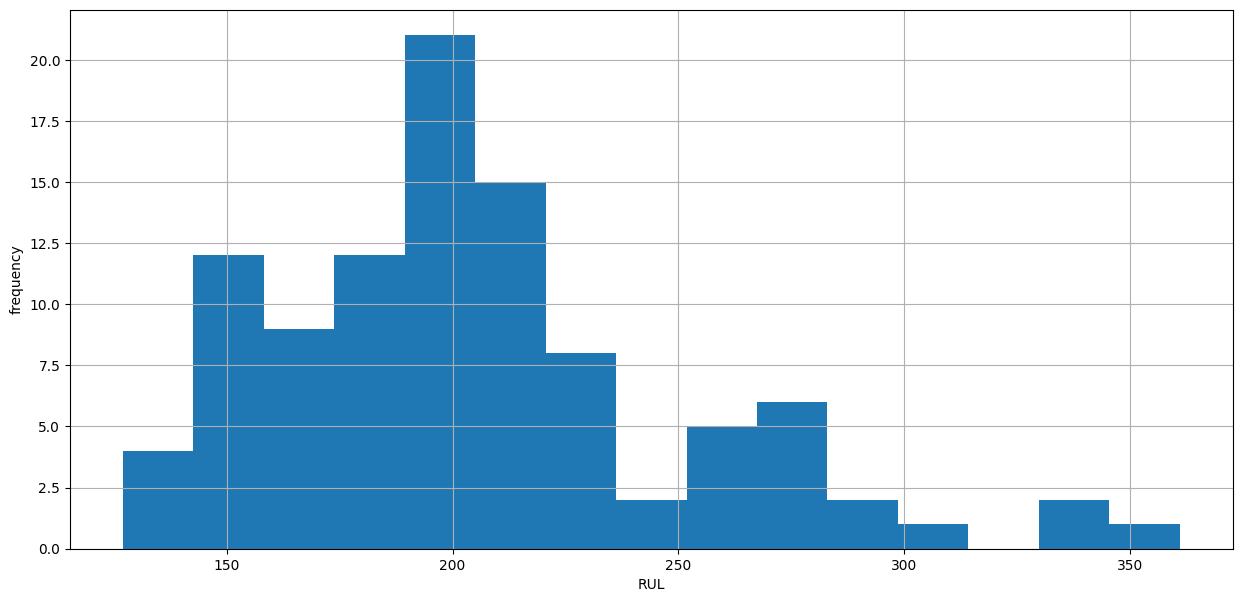

In [46]:
df_max_rul = train[['unit_nr', 'RUL']].groupby('unit_nr').max().reset_index()
df_max_rul['RUL'].hist(bins=15, figsize=(15,7))
plt.xlabel('RUL')
plt.ylabel('frequency')
plt.show()
# Most Engines break down around 200 cycles and the distribution is right skewed

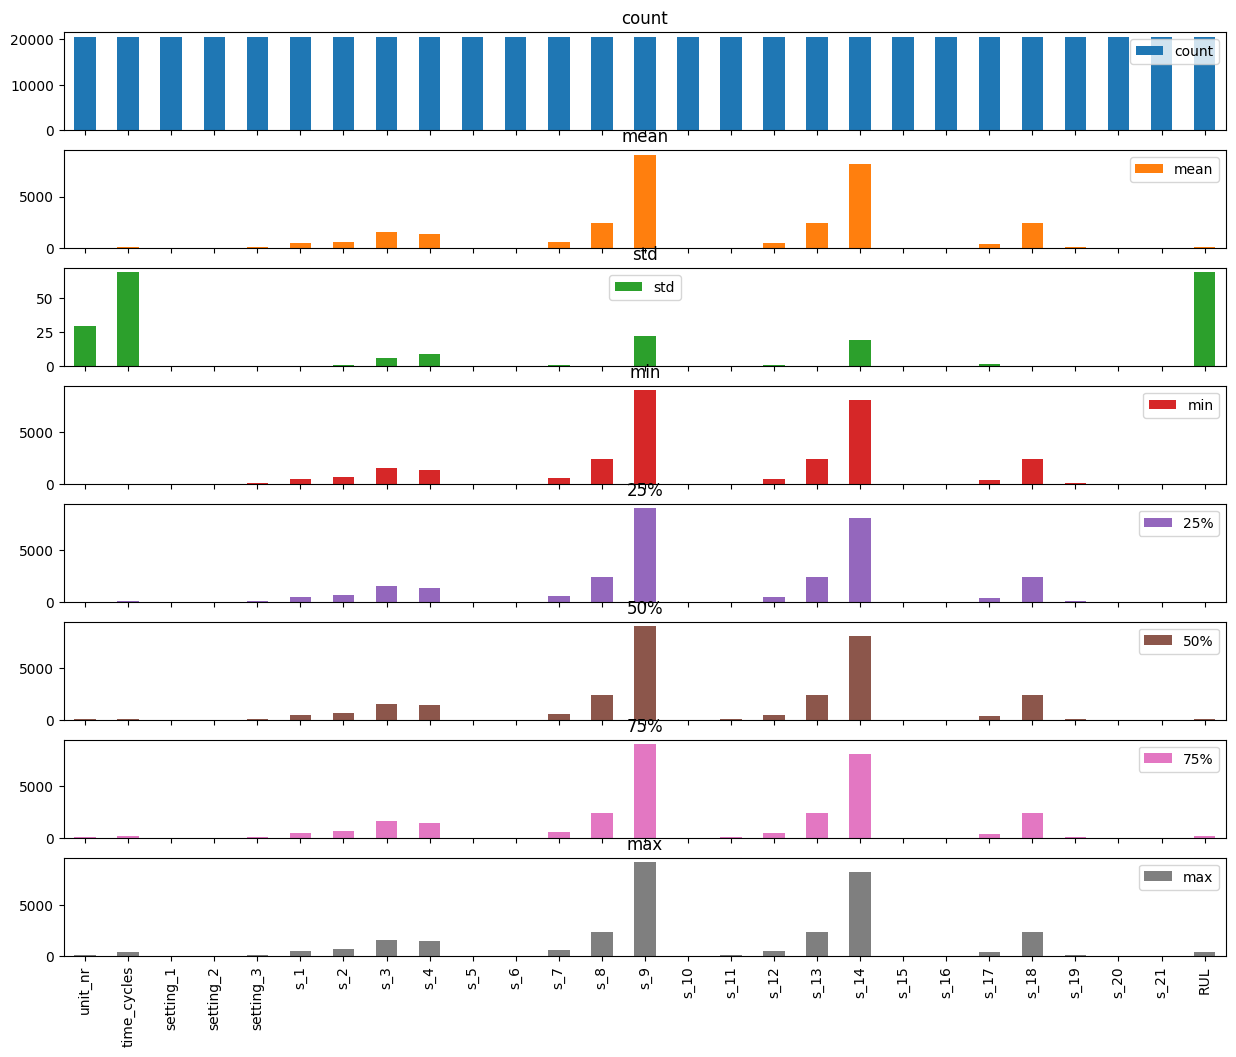

In [47]:
# plot of all columns
axes = train.describe().T.plot.bar(subplots=True, figsize=(15,12))

In [48]:
#There are a few columns with constant values
cols_const = [ col for col in train.columns if len(train[col].unique()) <= 2 ]
print('Columns with constant values: \n' + str(cols_const) + '\n')
#Columns with constant values: 
#['setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']

Columns with constant values: 
['setting_3', 's_1', 's_5', 's_6', 's_10', 's_16', 's_18', 's_19']



### Correlations

<Axes: >

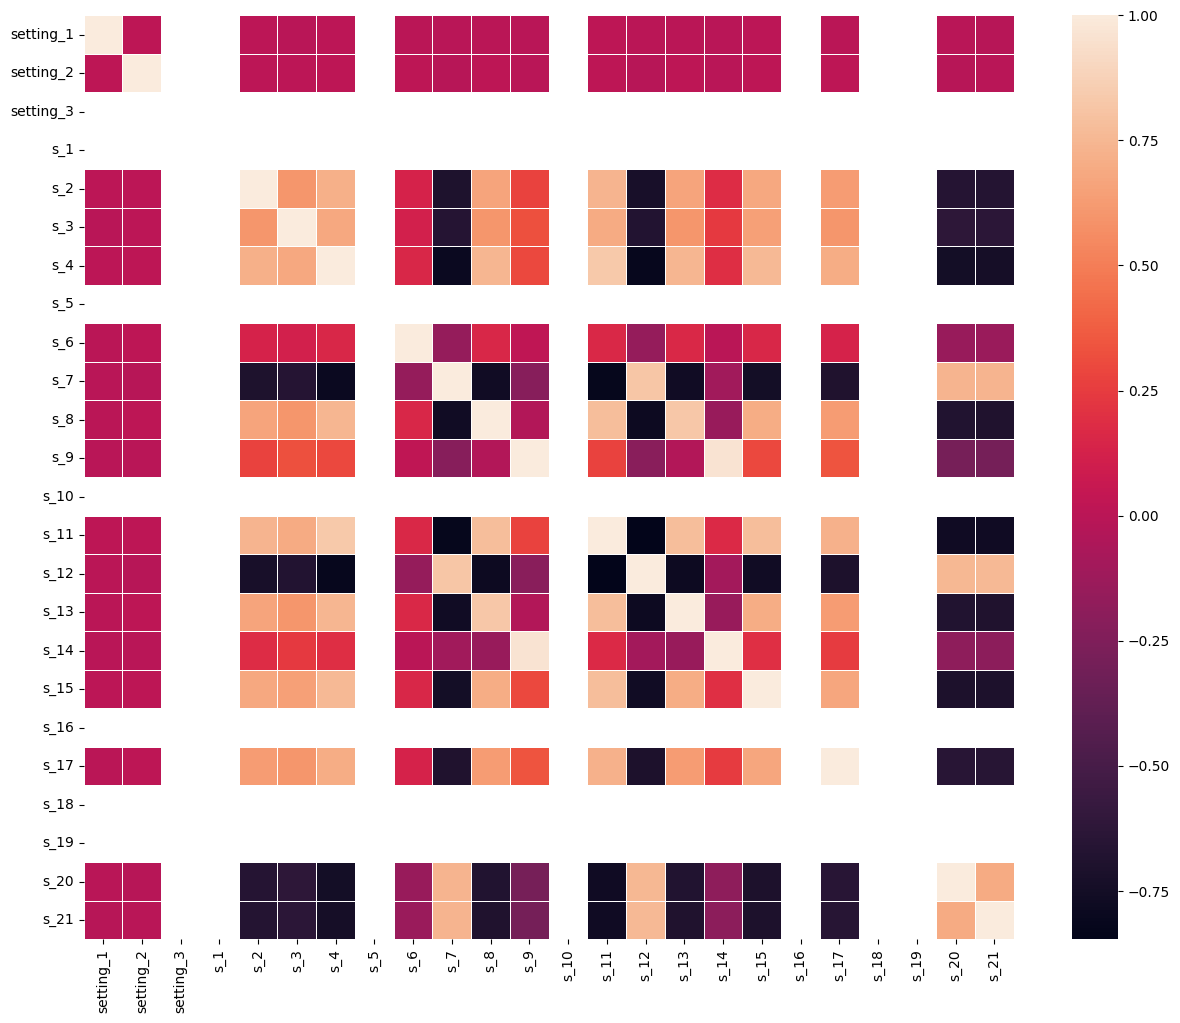

In [49]:
# print correlation heatmap
analysis_corr = train[setting_names + sensor_names].corr(method='pearson')
fig, ax = plt.subplots(figsize=(15,12))
sns.heatmap(analysis_corr, linewidths=.5)

In [50]:
# print highly correlated values
analysis_corr2 = pd.DataFrame(np.tril(analysis_corr.values), columns=analysis_corr.columns, index = analysis_corr.index)

correlating = []
for col in analysis_corr2.columns:
    ser = analysis_corr2[col]
    idx = np.logical_or(-0.8 > ser,  ser > 0.8)
    for i, c in zip(ser[idx].index, ser[idx].values):
        if (i, col, c) not in correlating and i != col:
            correlating.append((col, i, c))

print('Highly correlating values:')
for c in correlating:
    print(c)

Highly correlating values:
('s_4', 's_11', 0.8301356963159815)
('s_4', 's_12', -0.815590516105214)
('s_7', 's_11', -0.8228050249957691)
('s_7', 's_12', 0.812712601325414)
('s_8', 's_13', 0.8260843322333569)
('s_9', 's_14', 0.9631566003059776)
('s_11', 's_12', -0.8468835930051095)


### Trends

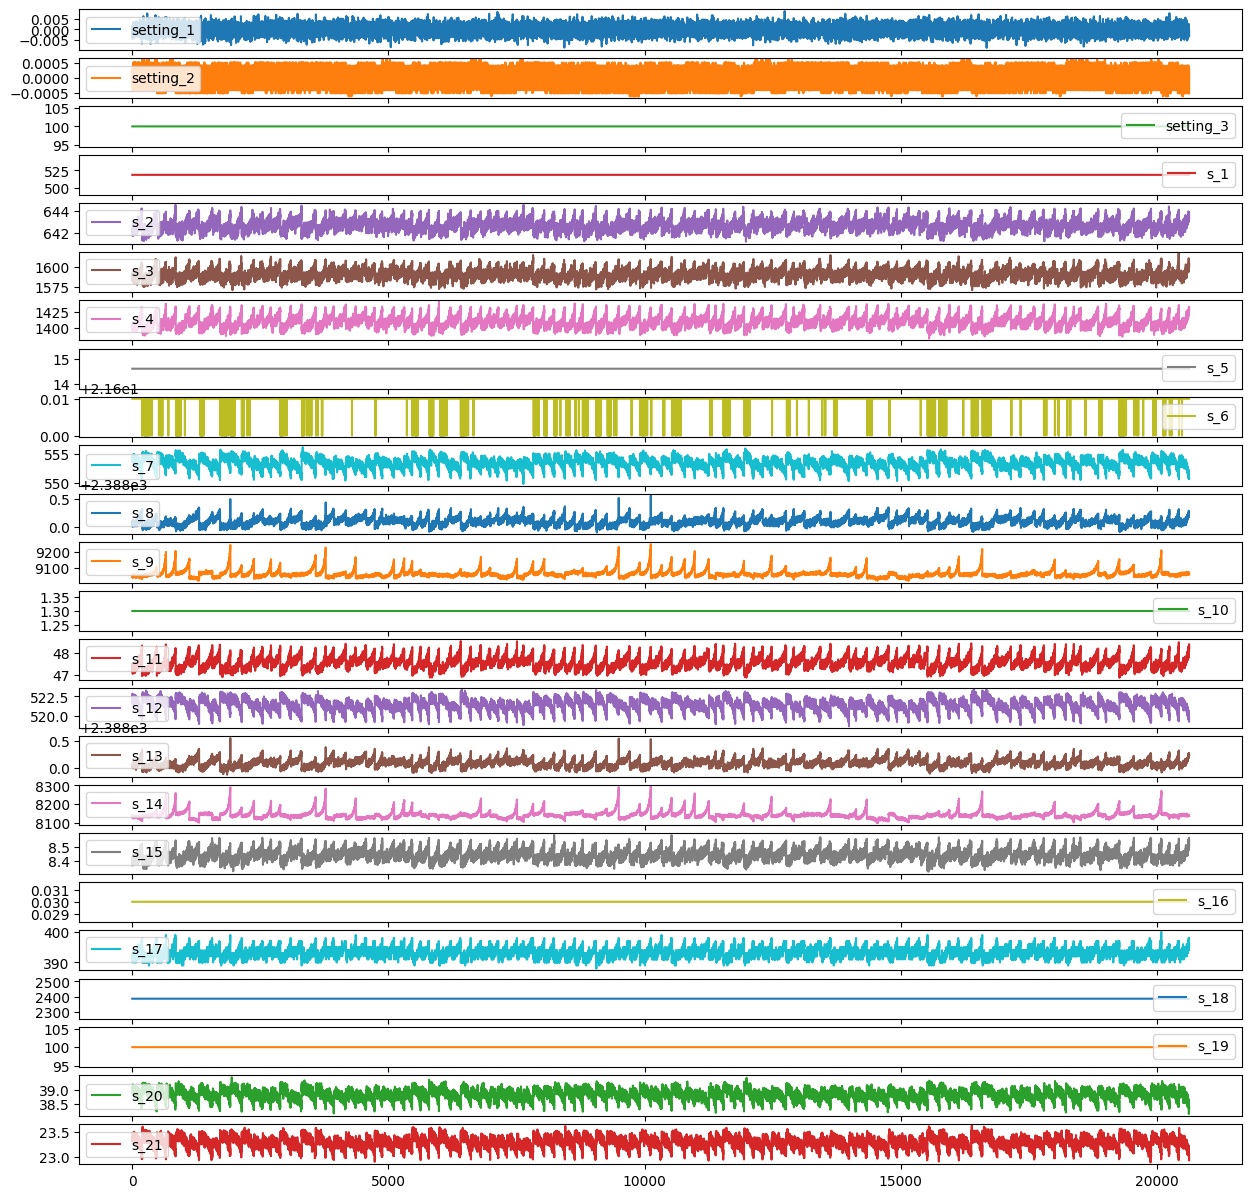

In [51]:
# plot all train data - settings, sensors
t = train[setting_names + sensor_names].plot(subplots=True, figsize=(15, 15))

In [52]:
# Plot each sensor
def plot_sensor(sensor_name):
    plt.figure(figsize=(13,5))
    for i in train['unit_nr'].unique():
        if (i % 15 == 0):  # only plot every 10th unit_nr
            plt.plot('RUL', sensor_name, 
                     data=train[train['unit_nr']==i])
    plt.xlim(250, 0)  # reverse the x-axis so RUL counts down to zero
    plt.xticks(np.arange(0, 275, 25))
    plt.ylabel(sensor_name)
    plt.xlabel('Remaining Useful Life')
    plt.show()

for sensor_name in sensor_names:
    plot_sensor(sensor_name)

# Plot Sensors w.r.t RUL and observe the trends
# Constant : Sensors 1, 5, 10, 16, 18, 19 
# Rising Trend : Sensors 2, 3, 4, 8, 11, 13, 15, 17 
# Declining Trend: Sensor 7, 12, 20, 21 
# Others: 
#        Sensor 6 peaks downwards. 
#        Sensors 9, 14 display similar pattern, gradual change for a while and then abrupt increase or decrease.

Output hidden; open in https://colab.research.google.com to view.

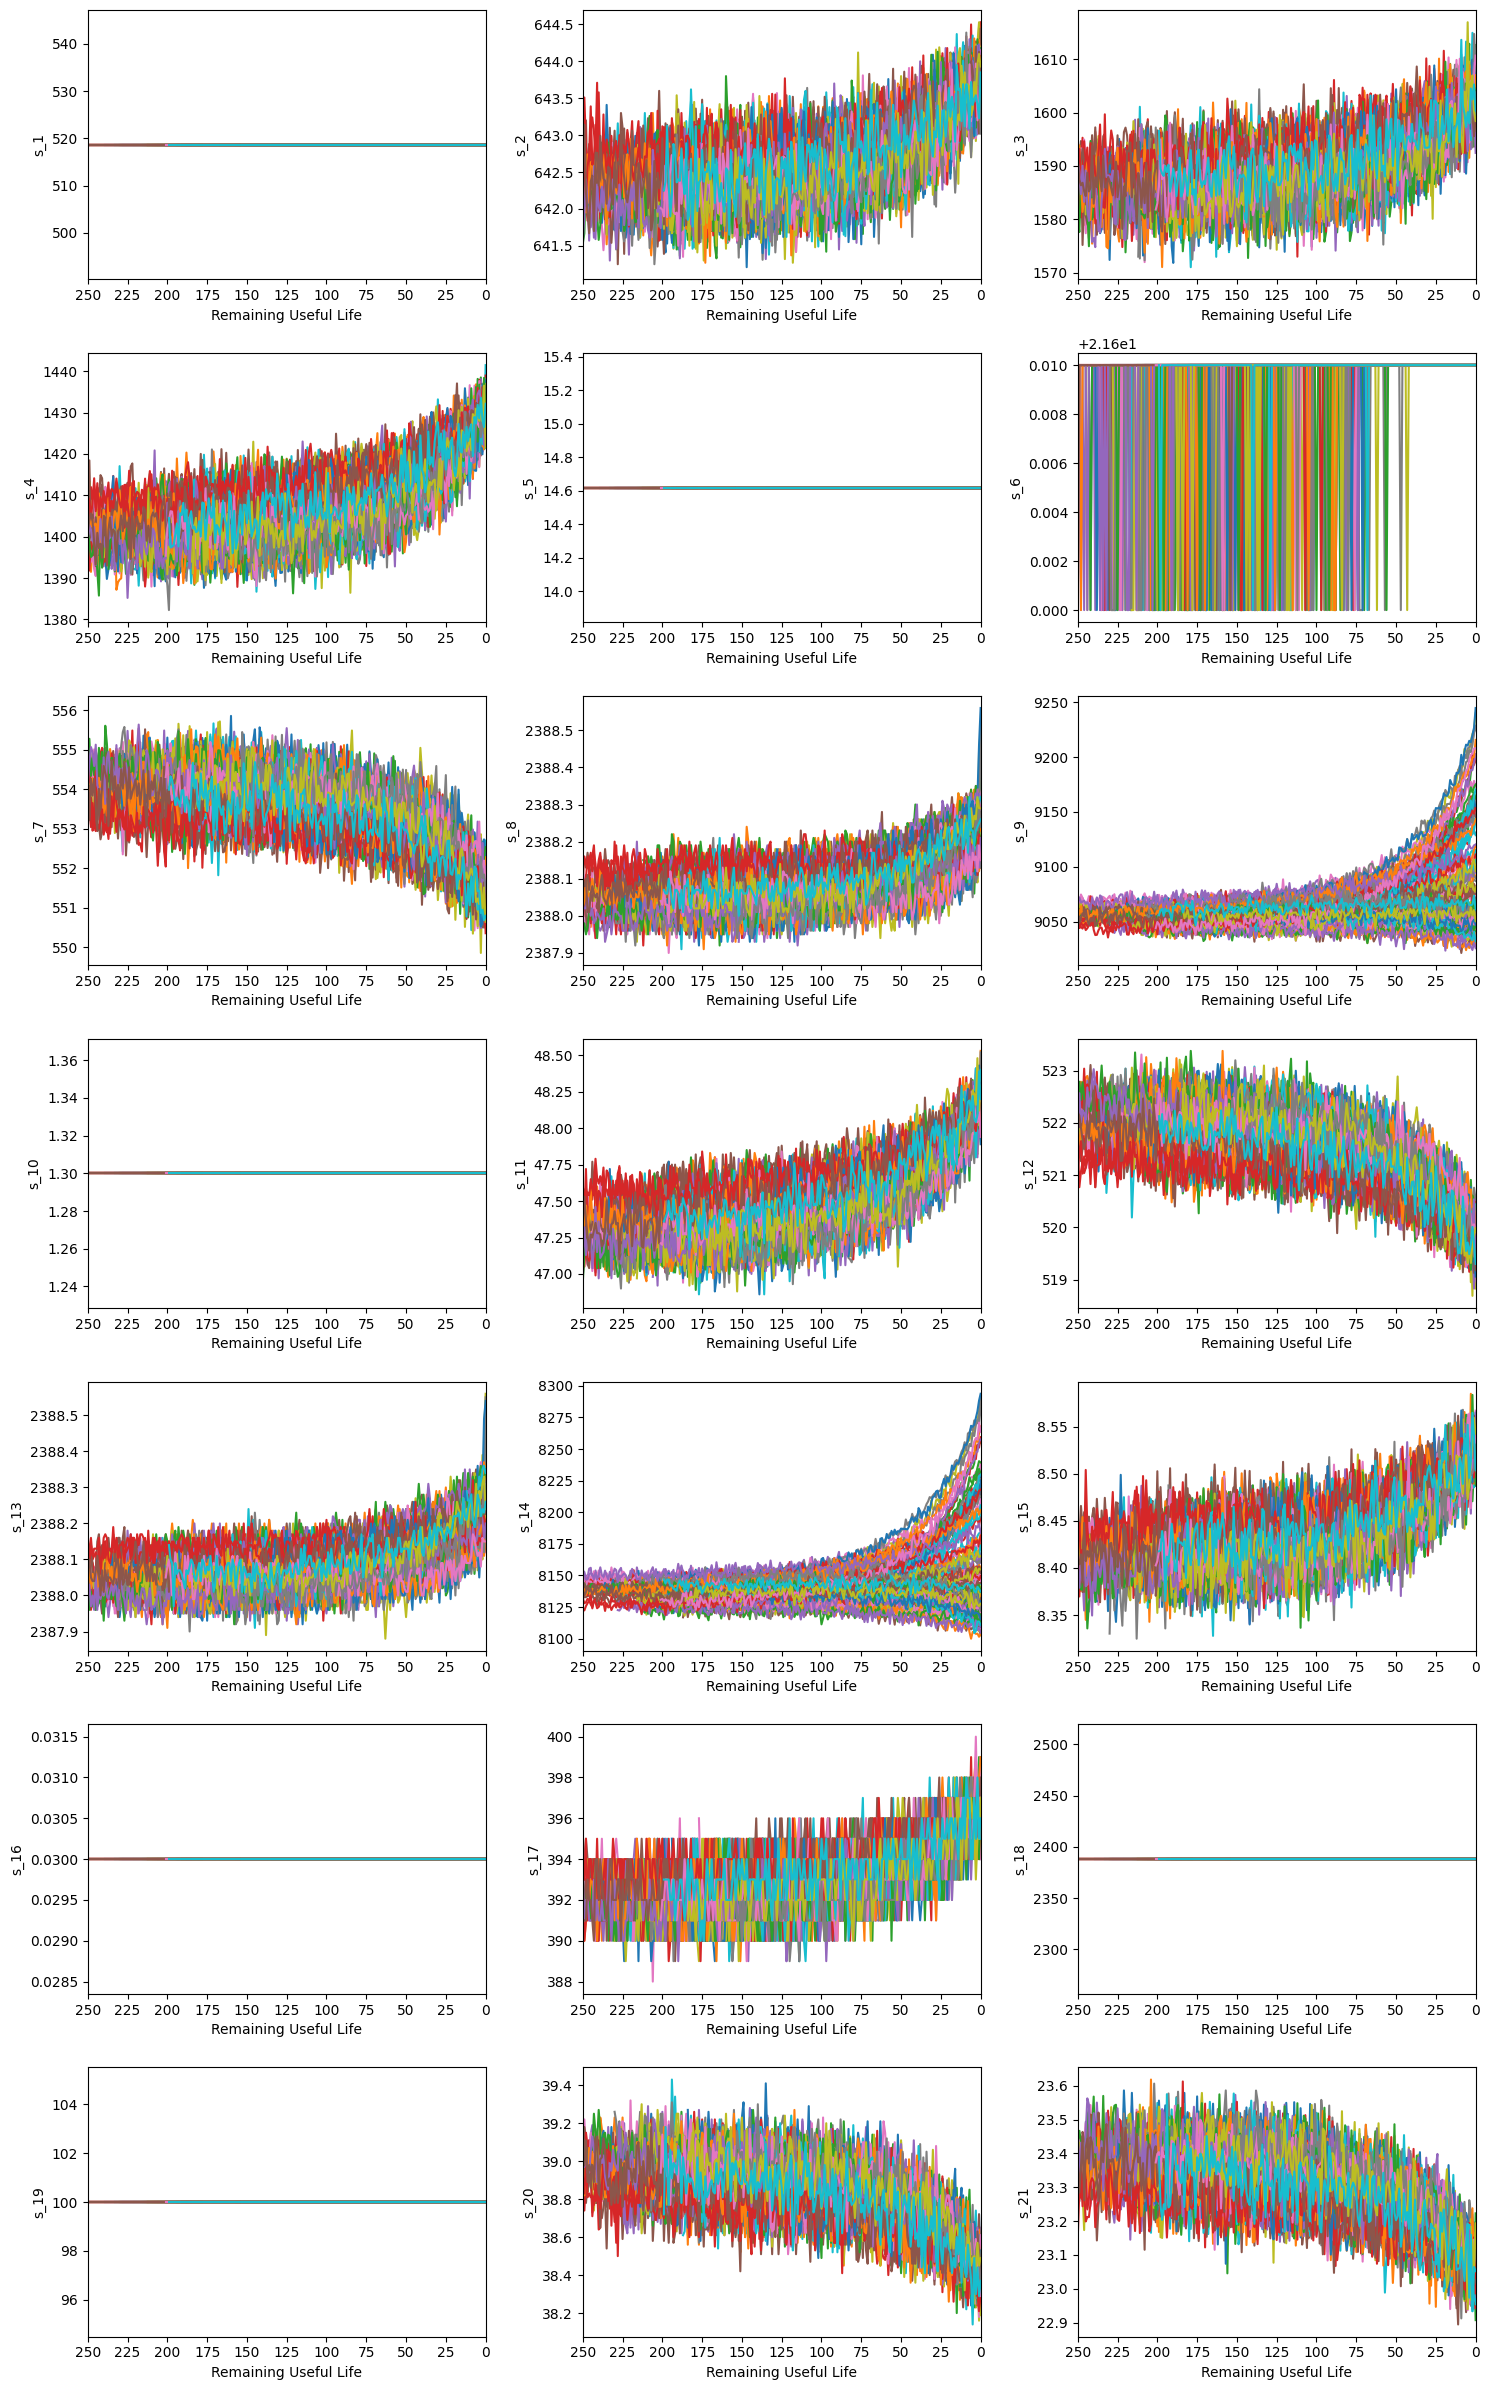

In [53]:
fig, axs = plt.subplots(nrows=7, ncols=3, figsize=(15, 24))

for i, sensor_name in enumerate(sensor_names):
    row = i // 3
    col = i % 3
    ax = axs[row, col]
    for j in train['unit_nr'].unique():
        #if (j % 10 == 0):
            ax.plot('RUL', sensor_name, data=train[train['unit_nr']==j])
    ax.set_xlim(250, 0)
    ax.set_xticks(np.arange(0, 275, 25))
    ax.set_ylabel(sensor_name)
    ax.set_xlabel('Remaining Useful Life')

plt.tight_layout()
plt.show()


In [54]:
sensor_names

['s_1',
 's_2',
 's_3',
 's_4',
 's_5',
 's_6',
 's_7',
 's_8',
 's_9',
 's_10',
 's_11',
 's_12',
 's_13',
 's_14',
 's_15',
 's_16',
 's_17',
 's_18',
 's_19',
 's_20',
 's_21']

### Baseline Model

Define a  function to evaluate our models. Root Mean Squared Error (RMSE) gives an indication how many time cycles the predictions are off on average, and Explained Variance (or R² score)  indicates what proportion of our dependent variable can be explained by the independent variables we use.

In [55]:
def evaluate(y_true, y_hat, label='test'):
    mse = mean_squared_error(y_true, y_hat)
    rmse = np.sqrt(mse)
    variance = r2_score(y_true, y_hat)
    print('{} set RMSE:{}, R2:{}'.format(label, rmse, variance))

Drop the unit_nr, time_cycle, settings and sensors which hold no information. The RUL column of the training set is stored in its own variable. For  test set we drop the same columns. In addition, we are only interested in the last time cycle of each engine in the test set as we only have True RUL values for those records.

In [56]:

drop_sensors = ['s_1','s_5','s_6','s_10','s_16','s_18','s_19']
drop_labels = index_names+setting_names+drop_sensors

X_train = train.drop(drop_labels, axis=1)
y_train = X_train.pop('RUL')

# Since the true RUL values for the test set are only provided for the last time cycle of each engine, 
# the test set is subsetted to represent the same
X_test = test.groupby('unit_nr').last().reset_index().drop(drop_labels, axis=1)

Setting up  linear regression

In [57]:
# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:44.66819159545438, R2:0.5794486527796744
test set RMSE:31.952633027730382, R2:0.40877368076616405


### Linear Model with clipped RUL

RUL : We assumed RUL to decline linearly over time. However, looking at the sensor signals, many sensors seem constant in the beginning. This is because the engines develop a fault over time. We can update the asumption to consider this. Instead of having RUL decline linearly, we can define RUL to start as constant and only decline linearly after sometime. Using pandas, we can simply clip the previously computed linearly declining RUL at the desired upper bound value. Testing multiple upper bound values indicated clipping RUL at 125 yielded the biggest improvement for the model.

In [59]:
## Clipped RUL 
y_train_clipped = y_train.clip(upper=125)

# create and fit model
lm = LinearRegression()
lm.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = lm.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = lm.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:21.491018701515106, R2:0.7340432868050524
test set RMSE:21.90021340689146, R2:0.7222608196546001


The test RMSE reduced from 31.95 to 21.90, an improvement of 31%

### Tuned SVR, Clipped RUL for training, feature scaling

Support Vector Regression (SVR) with scaling to have  features within the same range, and using feature engineering technique of creating polynomial combinations of  features

In [64]:
# Scaling
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

# SVM regression + clipped RUL + scaled
svr = SVR(kernel='linear')
svr.fit(X_train_scaled, y_train_clipped)

# predict and evaluate
y_hat_train = svr.predict(X_train_scaled)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr.predict(X_test_scaled)
evaluate(y_test, y_hat_test)


train set RMSE:21.578263975067888, R2:0.7318795396979632
test set RMSE:21.580480163289597, R2:0.730311354095216


In [65]:
from sklearn.preprocessing import PolynomialFeatures
# 2nd degree polynomialFeatures of [a, b] becomes [1, a, b, a^2, ab, b^2]
poly = PolynomialFeatures(2)
X_train_transformed = poly.fit_transform(X_train_scaled)
X_test_transformed = poly.fit_transform(X_test_scaled)

print(X_train_scaled.shape)
print(X_train_transformed.shape)

(20631, 14)
(20631, 120)


In [66]:
# SVM regression + clipped RUL + engineered features
svr_f = SVR(kernel='linear')
svr_f.fit(X_train_transformed, y_train_clipped)

# predict and evaluate
y_hat_train = svr_f.predict(X_train_transformed)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = svr_f.predict(X_test_transformed)
evaluate(y_test, y_hat_test)

train set RMSE:19.716789731130877, R2:0.7761436785704134
test set RMSE:20.58540250837201, R2:0.7546086882114963


### Random Forest

In [69]:
rf = RandomForestRegressor()

rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:6.844028310016897, R2:0.973027540630158
test set RMSE:18.44831539734726, R2:0.8029148576128735


In [68]:
rf = RandomForestRegressor(n_estimators=100, max_features="sqrt", random_state=42,
                           min_samples_leaf=11, min_impurity_decrease=0.0, 
                           max_depth=15, ccp_alpha=0.125)

rf.fit(X_train, y_train_clipped)

# predict and evaluate
y_hat_train = rf.predict(X_train)
evaluate(y_train_clipped, y_hat_train, 'train')

y_hat_test = rf.predict(X_test)
evaluate(y_test, y_hat_test)

train set RMSE:15.832547246222386, R2:0.855656065740048
test set RMSE:17.882012329449683, R2:0.814828887513805


### Centralized Learning on CMAPSS FD001 Data - Summary of RMSE Metrics

**Trained Models**<BR>
Baseline Linear Regression : 31.952633027730382  <BR>
Clipped RUL Linear : 21.90021340689146 <BR>
SVR: 20.58540250837201 <BR>
Random Forest: 17.882012329449683 <BR><BR>

**External Benchmark Models**<BR>
Deep LSTM:  18.43 <BR>
Hybrid CNN: 13.73 - 28.64<BR>
Hybrid SVR:  19.11<BR>
Random Forest: 12.01<BR>
